In [268]:
import pandas as pd
import numpy as np
import yfinance as yf
from QuantLib import *
import matplotlib.pyplot as plt
from datetime import timedelta

In [269]:
# Define stocks and options with weights
stocks = {
    'NVDA': {'weight': 0.021},  
    'PLTR': {'weight': 0.014},  
    'VRSN': {'weight': 0.014},  
    'VKTX': {'weight': 0.014},  
    'GILD': {'weight': 0.021},  
    'TSLA': {'weight': 0.021},  
    '3690.HK': {'weight': 0.021},  
    '1211.HK': {'weight': 0.014}   
}

options = {
    'NVDA': {'type': 'call', 'strike': 1.03, 'weight': 0.009},  
    'PLTR': {'type': 'call', 'strike': 1.02, 'weight': 0.006},  
    'VRSN': {'type': 'call', 'strike': 0.98, 'weight': 0.006},  
    'VKTX': {'type': 'call', 'strike': 1.02, 'weight': 0.006},  
    'GILD': {'type': 'call', 'strike': 0.98, 'weight': 0.009},  
    'TSLA': {'type': 'call', 'strike': 1.03, 'weight': 0.009},  
    '3690.HK': {'type': 'call', 'strike': 1.03, 'weight': 0.009},  
    '1211.HK': {'type': 'call', 'strike': 1.02, 'weight': 0.006}   
}

# Define crypto weights
crypto = {
    'BTC-USD': 0.015,
    'ETH-USD': 0.01
}

# Define bond returns and weights
bond_returns = {
    "Bloomberg MSCI Global Green Bond Index": 0.036,
    "VMBSNC Index ETF": 0.037,
    "Bloomberg US credit index": 0.054,
    "US 1 year Treasury": 0.04,
    "German 1 year bond": 0.025
}

bonds = {
    'Bloomberg MSCI Global Green Bond Index': 0.10,
    'VMBSNC Index ETF': 0.175,
    'Bloomberg US credit index': 0.15,
    'US 1 year Treasury': 0.25,
    'German 1 year bond': 0.10
}

def calculate_total_weights(stocks, options, crypto, bonds):
    total_weight = (
        sum(stock['weight'] for stock in stocks.values()) +
        sum(option['weight'] for option in options.values()) +
        sum(crypto.values()) +
        sum(bonds.values())
    )
    return total_weight

def normalize_all_weights(stocks, options, crypto, bonds):
    total_weight = calculate_total_weights(stocks, options, crypto, bonds)
    
    normalized_stocks = {k: {**v, 'weight': v['weight'] / total_weight} for k, v in stocks.items()}
    normalized_options = {k: {**v, 'weight': v['weight'] / total_weight} for k, v in options.items()}
    normalized_crypto = {k: v / total_weight for k, v in crypto.items()}
    normalized_bonds = {k: v / total_weight for k, v in bonds.items()}
    
    return normalized_stocks, normalized_options, normalized_crypto, normalized_bonds

# Normalize weights
normalized_stocks, normalized_options, normalized_crypto, normalized_bonds = normalize_all_weights(stocks, options, crypto, bonds)

# Verify the total weight
total_weight = (
    sum(stock['weight'] for stock in normalized_stocks.values()) +
    sum(option['weight'] for option in normalized_options.values()) +
    sum(normalized_crypto.values()) +
    sum(normalized_bonds.values())
)

# print(f"Total portfolio weight: {total_weight:.6f}")  # This should be very close to 1.0

Total portfolio weight: 1.000000


In [270]:
# Bull start="2020-10-01", end="2021-10-01", Bear: start="2022-01-01", end="2023-01-01"

# Download stock data for stocks and options
stock_data = yf.download(list(stocks.keys()), start="2020-10-01", end="2021-10-01", timeout=30)['Adj Close']

# Download crypto data
crypto_data = yf.download(list(crypto.keys()), start="2020-10-01", end="2021-10-01", timeout=30)['Adj Close']

# Handle missing data by forward-filling
stock_data.fillna(method='ffill', inplace=True)
crypto_data.fillna(method='ffill', inplace=True)

stock_returns = stock_data.pct_change()
crypto_returns = crypto_data.pct_change()

[************          25%                       ]  2 of 8 completed

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  2 of 2 completed


In [271]:
# Function for option pricing 
def option_price_quantlib(S, K, T, r, sigma, option_type='call'):
    calculation_date = Date(1, 10, 2020)
    Settings.instance().evaluationDate = calculation_date
    payoff = PlainVanillaPayoff(Option.Call if option_type == 'call' else Option.Put, K)
    exercise = EuropeanExercise(calculation_date + int(T * 365))
    option = EuropeanOption(payoff, exercise)
    spot_handle = QuoteHandle(SimpleQuote(S))
    flat_ts = YieldTermStructureHandle(FlatForward(calculation_date, r, Actual360()))
    vol_handle = BlackVolTermStructureHandle(BlackConstantVol(calculation_date, TARGET(), sigma, Actual360()))
    bsm_process = BlackScholesProcess(spot_handle, flat_ts, vol_handle)
    option.setPricingEngine(AnalyticEuropeanEngine(bsm_process))
    return option.NPV()

# Function to calculate option returns with a 6-month expiry and semi-annual roll
def calculate_option_returns(stock_data, initial_strike, risk_free_rate, volatility, option_type='call'):
    option_prices = []
    last_roll_date = stock_data.index[0]
    current_strike = initial_strike

    for date in stock_data.index:
        S = stock_data.loc[date]
        
        # Roll the option every 6 months
        if (date - last_roll_date).days >= 180:
            if pd.notna(S) and S > 0 and pd.notna(stock_data.loc[last_roll_date]) and stock_data.loc[last_roll_date] > 0:
                current_strike = S * (initial_strike / stock_data.loc[last_roll_date])
            else:
                current_strike = initial_strike  # Fallback to initial strike if we can't calculate new strike
            last_roll_date = date

        T = 1  # 6-month expiry
        sigma = volatility.loc[date]
        
        if pd.notna(S) and S > 0 and pd.notna(current_strike) and current_strike > 0 and pd.notna(sigma) and sigma > 0:  
            try:
                option_price = option_price_quantlib(S, current_strike, T, risk_free_rate, sigma, option_type)
                option_prices.append(option_price)
            except RuntimeError:
                option_prices.append(np.nan)
        else:
            option_prices.append(np.nan)

    option_prices = pd.Series(option_prices, index=stock_data.index)
    option_returns = option_prices.pct_change().fillna(0)
    
    # Cap extreme returns
    option_returns = option_returns.clip(lower=-0.5, upper=0.5)
    
    return option_returns

In [272]:
# Initialize performance series for each asset class
stock_performance = pd.Series(0, index=stock_returns.index)
option_performance = pd.Series(0, index=stock_returns.index)
crypto_performance = pd.Series(0, index=stock_returns.index)
bond_performance = pd.Series(0, index=stock_returns.index)

# Calculate returns for each asset class
for stock, params in normalized_stocks.items():
    stock_returns_weighted = stock_returns[stock] * params['weight']
    stock_performance += stock_returns_weighted

for stock, params in normalized_options.items():
    initial_strike = stock_data[stock].iloc[0] * params['strike']
    rolling_volatility = stock_returns[stock].rolling(window=21).std() * np.sqrt(252)
    option_returns = calculate_option_returns(
        stock_data[stock],
        initial_strike,
        0.04,  # Risk-free rate
        rolling_volatility,
        params['type']
    )
    option_returns_weighted = option_returns * params['weight']
    option_performance += option_returns_weighted

for coin, weight in normalized_crypto.items():
    crypto_returns_weighted = crypto_returns[coin] * weight
    crypto_performance += crypto_returns_weighted

for bond, weight in normalized_bonds.items():
    daily_return = bond_returns[bond] / 252  # Assuming 252 trading days in a year
    bond_returns_weighted = pd.Series(daily_return, index=stock_returns.index) * weight
    bond_performance += bond_returns_weighted

# Calculate overall portfolio returns
portfolio_returns = stock_performance + option_performance + crypto_performance + bond_performance

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Implement coupon payments
coupon_dates = []
coupon_amounts = []
last_coupon_date = cumulative_returns.index[0]
cumulative_returns_with_coupons = cumulative_returns.copy()

for date, cum_return in cumulative_returns.items():
    days_since_last_coupon = (date - last_coupon_date).days
    if days_since_last_coupon >= 90:  # Check if a quarter has passed
        quarter_start_return = cumulative_returns.loc[last_coupon_date]
        quarter_return = (cum_return - quarter_start_return) / (1 + quarter_start_return)
        if quarter_return >= 0.04:  # 4% threshold
            coupon_amount = 0.01  # 1% coupon
            cumulative_returns_with_coupons.loc[date:] -= coupon_amount
            coupon_dates.append(date)
            coupon_amounts.append(coupon_amount)
            last_coupon_date = date
            print(f"Coupon paid on {date}: {coupon_amount:.2%}")  # Debug print

# Cap cumulative returns at 50%
cumulative_returns_with_coupons = cumulative_returns_with_coupons.clip(upper=0.5)

# Calculate portfolio metrics
def calculate_portfolio_metrics(returns, cumulative_returns):
    # Maximum Drawdown
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (assuming 4% annual risk-free rate)
    risk_free_rate = 0.04 / 252  # daily risk-free rate
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    return {
        "Max Drawdown": max_drawdown,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

metrics = calculate_portfolio_metrics(portfolio_returns, cumulative_returns_with_coupons)

# Early redemption check
six_month_date = cumulative_returns.index[0] + timedelta(days=180)
nine_month_date = cumulative_returns.index[0] + timedelta(days=270)
six_month_return = cumulative_returns.loc[six_month_date:].iloc[0]
nine_month_return = cumulative_returns.loc[nine_month_date:].iloc[0]

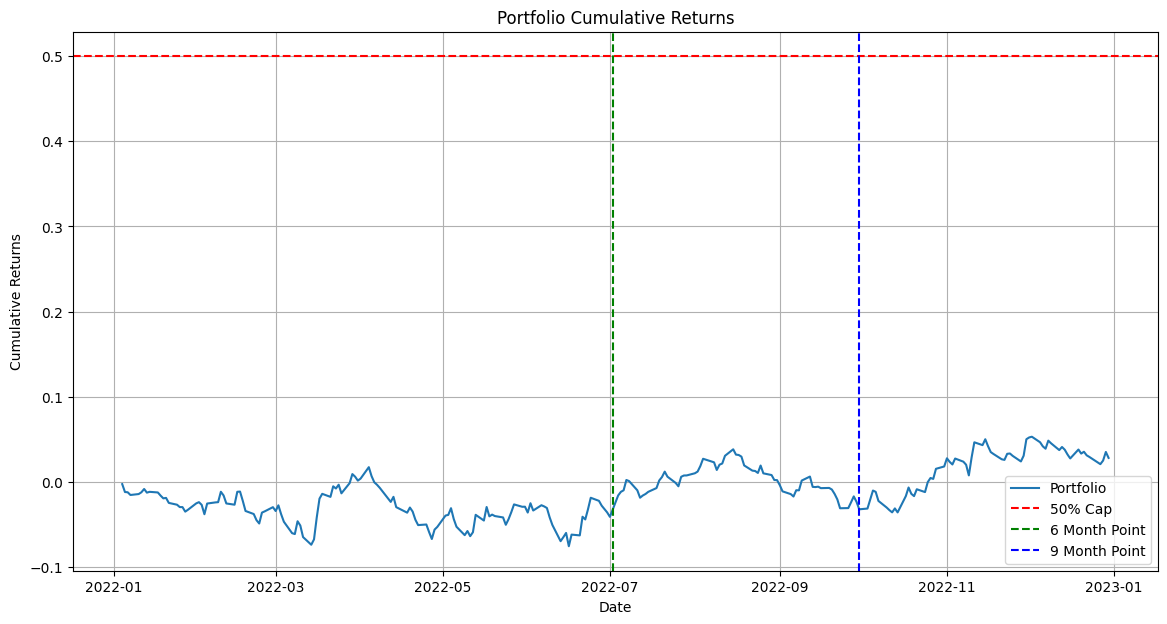

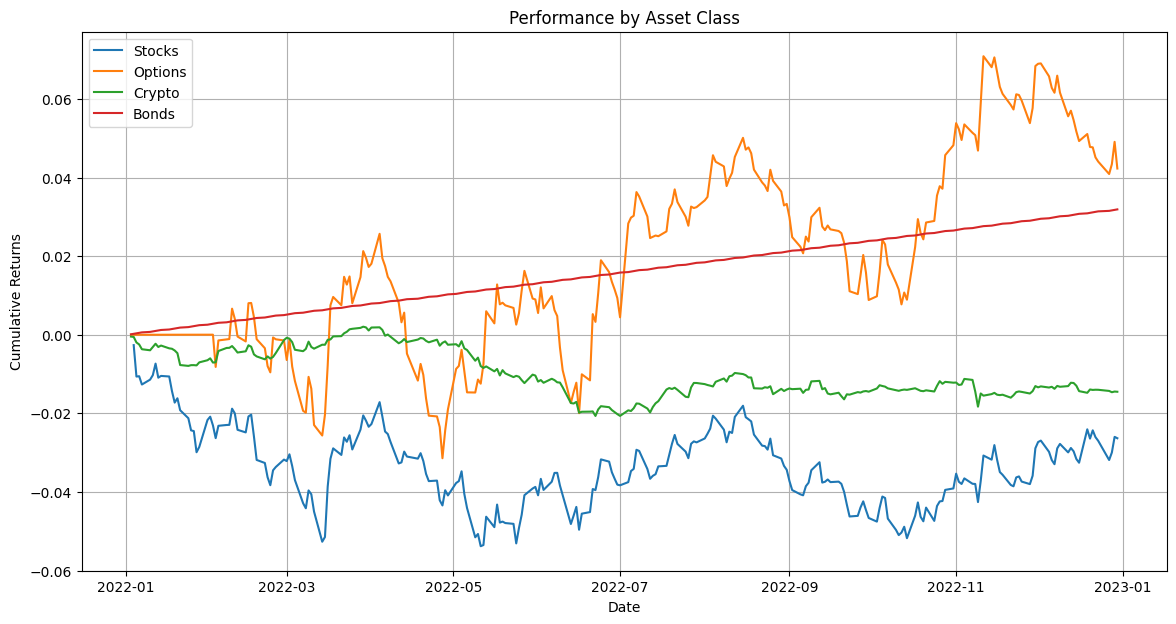


Performance Summary:
Overall Portfolio: 2.82%
Stocks: -2.63%
Options: 4.23%
Crypto: -1.45%
Bonds: 3.19%

Portfolio Metrics:
Maximum Drawdown: -536.40%
Annualized Volatility: 13.10%
Sharpe Ratio: -0.03

Early Redemption Check:
6-month return: -1.60%
9-month return: -3.22%

Coupon Payments:


In [273]:
# Plot cumulative returns with early redemption points, cap, and coupon payments
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns_with_coupons, label='Portfolio')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Cap')
plt.axvline(x=six_month_date, color='g', linestyle='--', label='6 Month Point')
plt.axvline(x=nine_month_date, color='b', linestyle='--', label='9 Month Point')

for date, amount in zip(coupon_dates, coupon_amounts):
    plt.axvline(x=date, color='m', linestyle=':', label='Coupon Payment' if date == coupon_dates[0] else '')
    plt.scatter(date, cumulative_returns_with_coupons.loc[date], color='m', s=100, zorder=5)
    plt.text(date, cumulative_returns_with_coupons.loc[date], f'-{amount:.1%}', 
             rotation=90, verticalalignment='bottom', horizontalalignment='right')

plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot performance of each asset class
plt.figure(figsize=(14, 7))
plt.plot((1 + stock_performance).cumprod() - 1, label='Stocks')
plt.plot((1 + option_performance).cumprod() - 1, label='Options')
plt.plot((1 + crypto_performance).cumprod() - 1, label='Crypto')
plt.plot((1 + bond_performance).cumprod() - 1, label='Bonds')
plt.title('Performance by Asset Class')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Print performance summary and metrics
print("\nPerformance Summary:")
print(f"Overall Portfolio: {cumulative_returns_with_coupons.iloc[-1]:.2%}")
print(f"Stocks: {((1 + stock_performance).prod() - 1):.2%}")
print(f"Options: {((1 + option_performance).prod() - 1):.2%}")
print(f"Crypto: {((1 + crypto_performance).prod() - 1):.2%}")
print(f"Bonds: {((1 + bond_performance).prod() - 1):.2%}")

print("\nPortfolio Metrics:")
print(f"Maximum Drawdown: {metrics['Max Drawdown']:.2%}")
print(f"Annualized Volatility: {metrics['Annualized Volatility']:.2%}")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")

print("\nEarly Redemption Check:")
print(f"6-month return: {cumulative_returns_with_coupons.loc[six_month_date:].iloc[0]:.2%}")
print(f"9-month return: {cumulative_returns_with_coupons.loc[nine_month_date:].iloc[0]:.2%}")

print("\nCoupon Payments:")
for date, amount in zip(coupon_dates, coupon_amounts):
    print(f"Date: {date.date()}, Amount: {amount:.2%}")